In [ ]:
%pylab osx

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors
from mpl_toolkits.mplot3d import Axes3D
import csv, os
import scipy.optimize
import scipy.special as ss
from common import *
from math import *
π = np.pi

In [26]:
Res = pd.DataFrame()

def load_folder (path):
    global Res
    for i in range(999):
        itempath = path+"/"+str(i)
        ppath = itempath+"-params.csv"
        if os.path.exists(ppath):
        #    res = {}
            df = pd.read_csv(ppath, sep=',', header=None)
            df = df.set_index(0).T
            if not 'mfpt' in df.columns:
                first_times = np.array(pd.read_csv(itempath+"-ft.csv", names=['ft'])['ft'])
                df['mfpt'] = np.mean(first_times)
                df['fpt_stdev'] = np.std(first_times)
                df['n_traj'] = len(first_times)
                del first_times
                df.T.to_csv(itempath+"-params.csv", header=False, quoting=csv.QUOTE_NONE, sep=',')
            if not 'Delta_t' in df.columns:
                df['Delta_t'] = 50 * 1.5e-6
            df['i'] = i
            if (df['Delta_t']/df['part_m']).iloc[0] < 1e-3 or df['part_m'].iloc[0] < 1e-5:
                Res = Res.append(df, ignore_index=True, sort=False)

#load_folder("data-poisson-fix-m0")
#load_folder("data-poisson-fix")
#reset_type = 'poisson'

load_folder("data-periodical-x0var")
reset_type = 'per'

len(Res)

147

In [27]:
Res['tau'] = 4*Res['D']*Res['mfpt']/Res['L']**2
Res['tau_err'] = 4*Res['D']*(Res['fpt_stdev']/np.sqrt(Res['n_traj']))/Res['L']**2

## Analyse pour reset poissonnien, $b=\infty$

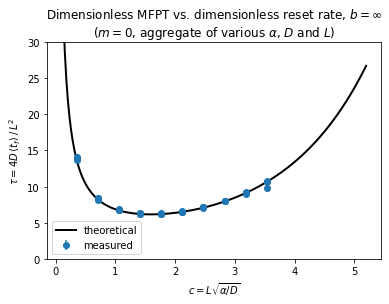

In [10]:
plt.errorbar(Res['c'], Res['tau'], yerr=Res['tau_err'], fmt='o', label="measured")
c = np.linspace(0.1,5.2,200)
plt.plot(c, fpt_poisson_tau(b=np.inf,c=c), label=r"theoretical", color='black', lw=2)
plt.ylim((0,30))
plt.legend(loc='lower left')
plt.xlabel(r"$c=L\sqrt{\alpha/D}$")
plt.ylabel(r"$\tau=4D\,\langle t_f\rangle\,/\,L^2$")
#plt.title(r"Dimensionless MFPT vs. dimensionless reset rate, $b=\infty$"+"\n"+r"($m/\gamma=2\cdot 10^{-4}$, aggregate of various $\alpha$, $D$ and $L$)")
plt.title(r"Dimensionless MFPT vs. dimensionless reset rate, $b=\infty$"+"\n"+r"($m=0$, aggregate of various $\alpha$, $D$ and $L$)")
plt.savefig("langevin-mfpt-c-b_inf.pdf", bbox_inches='tight')

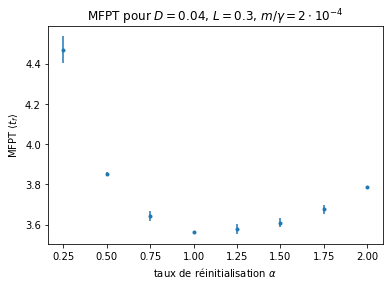

In [19]:
Res_binf_03 = Res[ (np.abs(Res['L'] - 0.30) < 1e-10) & (np.abs(Res['D'] - 0.04) < 1e-10) ].copy()
Res_binf_03['mfpt_err'] = Res_binf_03['fpt_stdev']/np.sqrt(Res_binf_03['n_traj'])
plt.errorbar(Res_binf_03['reset_rate'], Res_binf_03['mfpt'], yerr=Res_binf_03['mfpt_err'], fmt='.')
plt.xticks(Res_binf_03['reset_rate'])
plt.xlabel(r"taux de réinitialisation $\alpha$")
plt.ylabel(r"MFPT $\langle t_f\rangle$")
plt.title(r"MFPT pour $D=0.04$, $L=0.3$, $m/\gamma=2\cdot 10^{-4}$")
plt.savefig("langevin-mfpt-alpha-b_inf.pdf", bbox_inches='tight')

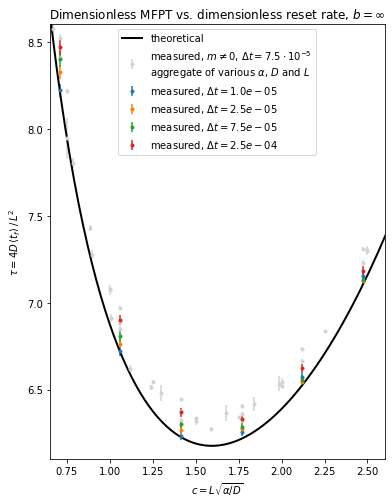

In [14]:
plt.figure(figsize=(6,8))
Res_mn0 = Res[ Res['part_m'] > 1e-3 ]
plt.errorbar(Res_mn0['c'], Res_mn0['tau'], yerr=Res_mn0['tau_err'], fmt='.', label=r"measured, $m\neq 0$, $\Delta t = 7.5\cdot 10^{-5}$"+"\n"+r"aggregate of various $\alpha$, $D$ and $L$", color='lightgray')
groups = Res[ Res['part_m'] < 1e-3 ].sort_values(by='Delta_t').groupby( Res['Delta_t'].apply(lambda x: round(x,6)) )
for Δt, Res_Δt in list(groups):
    plt.errorbar(Res_Δt['c'], Res_Δt['tau'], yerr=Res_Δt['tau_err'], fmt='.', label=r"measured, $\Delta t={:.1e}$".format(Δt))
c = np.linspace(0.1,5.2,200)
plt.plot(c, fpt_poisson_tau(b=np.inf,c=c), label=r"theoretical", color='black', lw=2)
plt.ylim((6.1,8.6))
plt.xlim((0.65,2.6))
plt.legend(loc='upper center')
plt.xlabel(r"$c=L\sqrt{\alpha/D}$")
plt.ylabel(r"$\tau=4D\,\langle t_f\rangle\,/\,L^2$")
plt.title(r"Dimensionless MFPT vs. dimensionless reset rate, $b=\infty$")
plt.savefig("langevin-mfpt-c-b_inf-zoom.pdf", bbox_inches='tight')

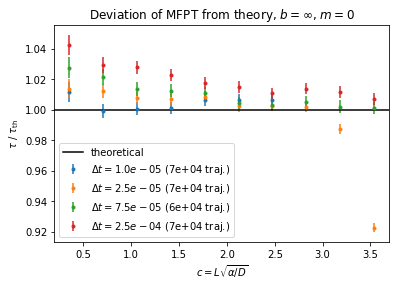

In [17]:
for Δt, Res_Δt in list(groups):
    plt.errorbar(Res_Δt['c'], Res_Δt['tau']/fpt_poisson_tau(b=np.inf,c=Res_Δt['c']),
                 yerr=Res_Δt['tau_err']/fpt_poisson_tau(np.inf,Res_Δt['c']),
                 fmt='.', label=r"$\Delta t={:.1e}$ ({:.0e} traj.)".format(Δt,Res_Δt['n_traj'].iloc[0]))
plt.xlabel(r"$c=L\sqrt{\alpha/D}$")
plt.ylabel(r"$\tau\ /\ \tau_\operatorname{th}$")
plt.axhline(y=1, color='black', label="theoretical")
plt.legend()
plt.title(r"Deviation of MFPT from theory, $b=\infty$, $m=0$")
plt.savefig("langevin-mfpt-c-b_inf-deviation.pdf", bbox_inches='tight')

## Analyse pour $b$ variable

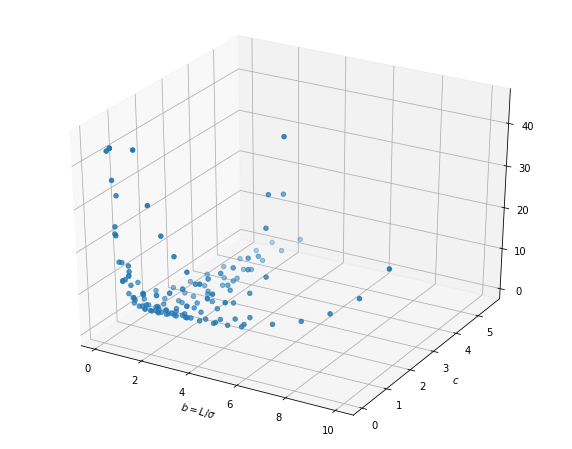

In [28]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(1,1,1, projection='3d')
Res_zlim = Res[ Res['tau'] < 50 ]
ax.scatter( Res_zlim['b'], Res_zlim['c'], Res_zlim['tau'] )
#ax.scatter( Res['b'], Res['c'], th_tau(Res['b'],Res['c']) )
plt.xlabel(r"$b=L/\sigma$")
plt.ylabel(r"$c$")
plt.savefig("3d-plot-"+reset_type+".pdf", bbox_inches='tight')
plt.show()

In [29]:
def do_grouping (Res, n_colors_max=13):
    groups = Res.groupby( Res['b'].apply(lambda x: round(x,2)) )
    group_pts_min = 1
    while True:
        colors = {}
        for b, Res_b in list(groups):
            if len(Res_b) > group_pts_min:
                colors[b] = None
        i = 0
        for k in colors.keys():
            colors[k] = matplotlib.colors.hsv_to_rgb((i/len(colors), 1, 1))
            i += 1
        if len(colors) <= n_colors_max:
            break
        else:
            group_pts_min += 1
    return groups, group_pts_min, colors

if reset_type == 'none':
    th_tau = None # TODO
elif reset_type == 'poisson':
    th_tau = fpt_poisson_tau # (b, c)
elif reset_type == 'per':
    th_tau = fpt_periodic_tau # (b, c)
    
def order_c_tau (Res_b, filter_f=None):
    c = np.array(Res_b['c'])
    i = np.argsort(c)
    c = c[i]
    tau = np.array(Res_b['tau'])[i]
    err = np.array(Res_b['tau_err'])[i]
    if filter_f is not None:
        i = filter_f(c, tau)
        c = c[i]
        tau = tau[i]
        err = err[i]
    return c, tau, err

def annotate_params (Res_b, f_pos = lambda c,tau: (c,tau)):
    for i in range(len(Res_b)):
        res = Res_b.iloc[i]
        # $\Delta t={:.1e}$
        #plt.annotate("$\\alpha={}$, $L={:.2f}$, $m={}$, $D={}$".format(res['reset_rate'],res['L'],res['part_m'],res['D']), f_pos(res['c'],res['tau']), size=6, ha='center', va='center')
        if reset_type == 'poisson':
            plt.annotate("$\\alpha={}$, $\\sigma={}$, $D={}$".format(res['reset_rate'],res['x0sigma'],res['D']), f_pos(res['c'],res['tau']), size=6, ha='center', va='center')
        elif reset_type == 'per':
            plt.annotate("$T={}$, $\\sigma={}$, $D={}$".format(res['reset_period'],res['x0sigma'],res['D']), f_pos(res['c'],res['tau']), size=6, ha='center', va='center')

def annotate_i (Res_b, f_pos = lambda c,tau: (c,tau)):
    for i in range(len(Res_b)):
        res = Res_b.iloc[i]
        plt.annotate(str(int(res['i'])), f_pos(res['c'],res['tau']), size=8, ha='center', va='center')

def show_labels():
    if reset_type == 'poisson':
        plt.xlabel(r"$c=L\sqrt{\alpha/D}$")
    elif reset_type == 'per':
        plt.xlabel(r"$c=L/\sqrt{4DT_\operatorname{res}}$")
    plt.ylabel(r"$\tau$")
    plt.legend()

In [36]:
tau_th_cache = {}

In [37]:
groups, group_pts_min, colors = do_grouping(Res, n_colors_max=13)
#groups, group_pts_min, colors = do_grouping(Res[ (1 <= Res['b']) & (Res['b'] <= 3) & (Res['c'] > 0.5) ], n_colors_max=13)

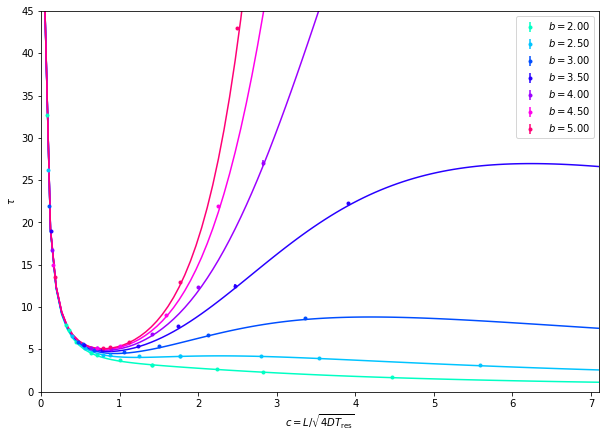

In [38]:
if reset_type == 'poisson': c_max = 12
elif reset_type == 'per': c_max = 7.1

plt.figure(figsize=(10,7))
for b, Res_b in list(groups):
    
    if b > 1.6 and len(Res_b) > group_pts_min:
        c = np.linspace(0.05, c_max, 100)
        name = 'highb'+str(b)
        if not (name in tau_th_cache):
            tau_th_cache[name] = th_tau(b,c)
        plt.plot(c, tau_th_cache[name], color=colors[b])
        c, tau, err = order_c_tau(Res_b)
        plt.errorbar(c, tau, label=r"$b={:.2f}$".format(b), color=colors[b], yerr=err, fmt='.')
        #annotate_i(Res_b)
        
plt.ylim((0,45))
plt.xlim((0,c_max))
show_labels()
plt.savefig("mfpt-"+reset_type+"-x0var-highb.pdf", bbox_inches='tight')
plt.show()

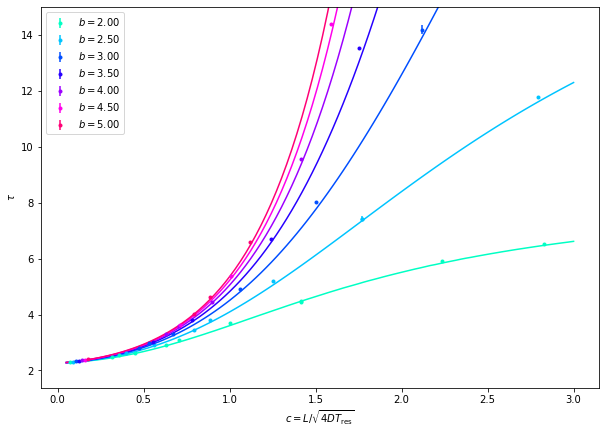

In [39]:
plt.figure(figsize=(10,7))
for b, Res_b in list(groups):
    
    if b > 1.6 and len(Res_b) > group_pts_min:
        c = np.linspace(0.05, 3, 100)
        name = 'highb-zoom'+str(b)
        if not (name in tau_th_cache):
            tau_th_cache[name] = th_tau(b,c)
        plt.plot(c, c*tau_th_cache[name], color=colors[b])
        c, tau, err = order_c_tau(Res_b, lambda c,_: c < 3)
        plt.errorbar(c, c*tau, label=r"$b={:.2f}$".format(b), color=colors[b], yerr=c*err, fmt='.')
        #annotate_params(Res_b)

plt.ylim((0.6*np.min(Res['c']*Res['tau']),15))
show_labels()
plt.savefig("mfpt-"+reset_type+"-x0var-highb-zoom.pdf", bbox_inches='tight')
plt.show()

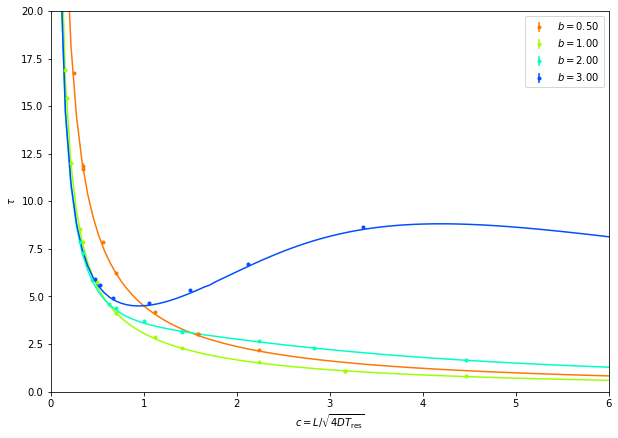

In [40]:
plt.figure(figsize=(10,7))
for b, Res_b in list(groups):
    
    if b in [0.5,1.0,2.0,3.0]:
        c = np.linspace(0.1, 6, 100)
        name = 'commonb'+str(b)
        if not (name in tau_th_cache):
            tau_th_cache[name] = th_tau(b,c)
        plt.plot(c, tau_th_cache[name], color=colors[b])
        c, tau, err = order_c_tau(Res_b)
        plt.errorbar(c, tau, label=r"$b={:.2f}$".format(b), color=colors[b], yerr=err, fmt='.')
        #annotate_params(Res_b)
        
plt.ylim((0,20))
plt.xlim((0,6))
show_labels()
plt.savefig("mfpt-"+reset_type+"-x0var-commonb.pdf", bbox_inches='tight')
plt.show()

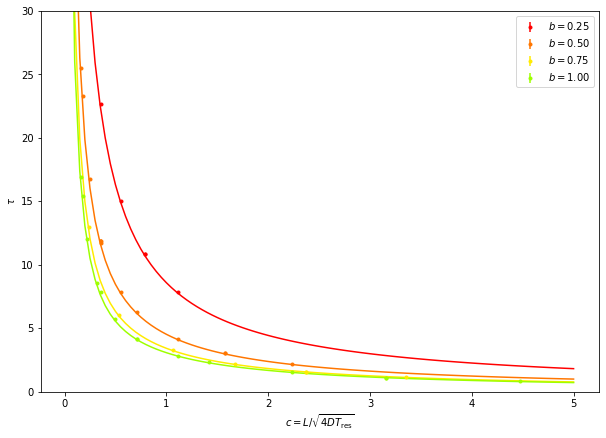

In [47]:
plt.figure(figsize=(10,7))
for b, Res_b in list(groups):
    
    if b < 1.1 and b > 0.1 and len(Res_b) > group_pts_min:
        c = np.linspace(0.05, 5, 100)
        name = 'lowb'+str(b)
        if not (name in tau_th_cache):
            tau_th_cache[name] = th_tau(b,c)
        plt.plot(c, tau_th_cache[name], color=colors[b])
        c, tau, err = order_c_tau(Res_b)
        plt.errorbar(c, tau, label=r"$b={:.2f}$".format(b), color=colors[b], yerr=err, fmt='.')

plt.ylim((0,30))
show_labels()
plt.savefig("mfpt-"+reset_type+"-x0var-lowb.pdf", bbox_inches='tight')
plt.show()

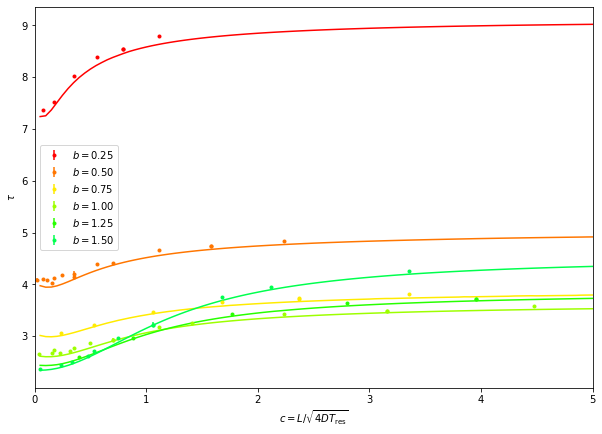

In [54]:
plt.figure(figsize=(10,7))
for b, Res_b in list(groups):
    
    if b < 1.6 and b > 0.1 and len(Res_b) > group_pts_min:
        c = np.linspace(0.05, 5, 100)
        name = 'lowb'+str(b)
        if not (name in tau_th_cache):
            tau_th_cache[name] = th_tau(b,c)
        plt.plot(c, c*tau_th_cache[name], color=colors[b])
        c, tau, err = order_c_tau(Res_b)
        plt.errorbar(c, c*tau, label=r"$b={:.2f}$".format(b), color=colors[b], yerr=c*err, fmt='.')

plt.xlim((0,5))
show_labels()
plt.savefig("mfpt-"+reset_type+"-x0var-lowb-zoom.pdf", bbox_inches='tight')
plt.show()

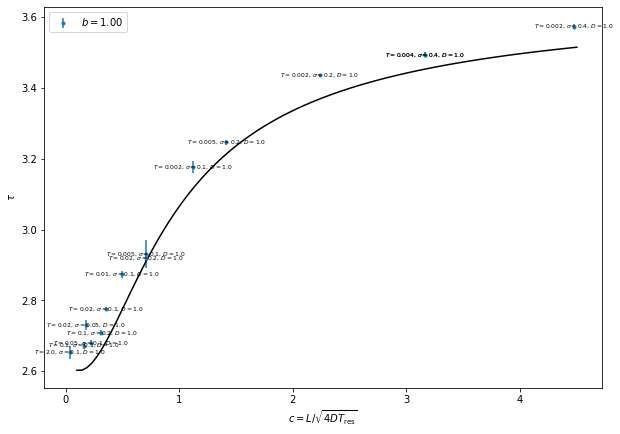

In [43]:
plt.figure(figsize=(10,7))
b = 1.0
Res_b = groups.get_group(b)
Res_b1 = Res_b[ Res_b['c'] < 5 ]
c = np.linspace(0.1, 4.5, 100)
plt.plot(c, c*th_tau(b,c), color='black')
c, tau, err = order_c_tau(Res_b1)
plt.errorbar(c, c*tau, label=r"$b={:.2f}$".format(b), yerr=c*err, fmt='.')
annotate_params(Res_b1, lambda c,tau: (c,c*tau))

show_labels()
plt.savefig("mfpt-"+reset_type+"-x0var-b{}.pdf".format(b), bbox_inches='tight')
plt.show()

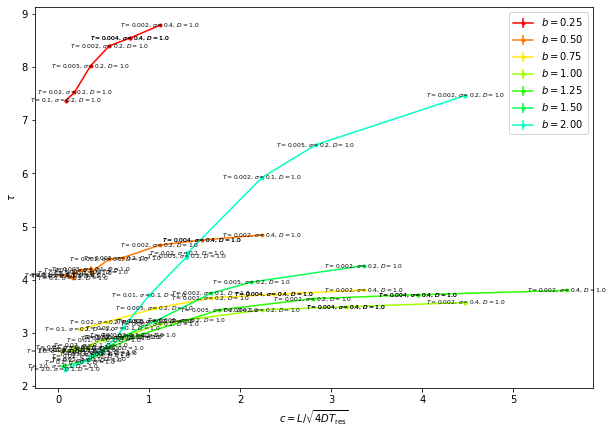

In [44]:
plt.figure(figsize=(10,7))
for b, Res_b in list(groups):
    
    if len(Res_b) > 3 and b <= 2 and len(Res_b) > group_pts_min:
        c, tau, err = order_c_tau(Res_b)
        plt.errorbar(c, c*tau, label=r"$b={:.2f}$".format(b), yerr=c*err, fmt='.-', color=colors[b])
        annotate_params(Res_b, f_pos = lambda c,tau: (c,c*tau))
        
show_labels()
plt.show()

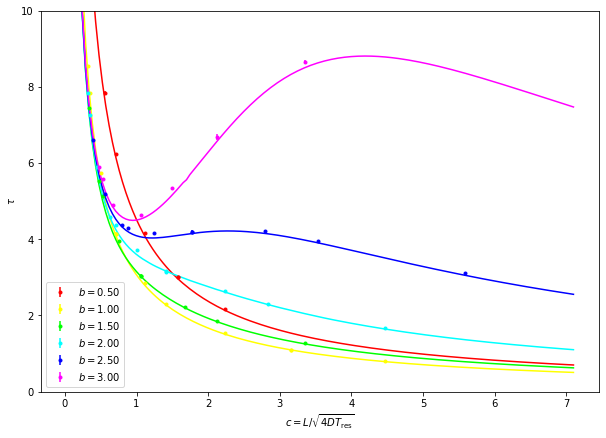

In [45]:
groups_6, group_pts_min_6, colors_6 = do_grouping(Res, n_colors_max=6)

plt.figure(figsize=(10,7))
for b, Res_b in list(groups_6):
    
    if len(Res_b) > group_pts_min_6:
        c = np.linspace(0.1, 7.1, 150)
        plt.plot(c, th_tau(b,c), color=colors_6[b])
        c, tau, err = order_c_tau(Res_b)
        plt.errorbar(c, tau, label=r"$b={:.2f}$".format(b), color=colors_6[b], yerr=err, fmt='.')
        
plt.ylim((0,10))
show_labels()
plt.savefig("mfpt-"+reset_type+"-x0var-all.pdf", bbox_inches='tight')
plt.show()